In [2]:
from MalardClient.DataSetQuery import DataSetQuery
from MalardClient.AsyncDataSetQuery import AsyncDataSetQuery 
import datetime
import MalardClient.MalardHelpers as mh

%matplotlib inline
from datetime import datetime

environmentName = 'DEVv2'
#Sets the URL of the Malard ServiceGateway.
query = DataSetQuery('http://localhost:9000',environmentName)
queryAsync = AsyncDataSetQuery('ws://localhost:9000',environmentName)


In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import pandas as pd
from math import floor

from matplotlib.collections import PatchCollection

def createPatch( ax, gminX, gmaxX, gminY, gmaxY ):
    
    inner_gminx = gminX + 10000
    inner_gmaxx = gmaxX - 10000
    inner_gminy = gminY + 10000
    inner_gmaxy = gmaxY - 10000
    
    inner_polygon = plt.Polygon([[inner_gminx, inner_gminy], [inner_gmaxx , inner_gminy], [inner_gmaxx ,inner_gmaxy], [inner_gminx, inner_gmaxy], [inner_gminx,inner_gminy]],color=None,ec='black') 
    return inner_polygon
    
    
def generateGridCellImage( parentDataSet, dataSet, region, size = 15 ):

    bbox = json.loads(query.getDataSetBoundingBox( parentDs,dataSet,region ))
    
    print(bbox)
    
    #Setup the bounding box
    minX = bbox['gridCellMinX']
    maxX = bbox['gridCellMaxX']
    minY = bbox['gridCellMinY']
    maxY = bbox['gridCellMaxY']
    minT = datetime(2019,1,1,0,0,0)#datetime.fromtimestamp( bbox['minTime'] )
    maxT = datetime(2019,1,31,23,59,59)#datetime.fromtimestamp( bbox['maxTime'] )
    
    print("MinT={} MaxT={}".format(minT, maxT) )

    gcs = json.loads(query.getGridCells(  parentDs,dataSet,region,minX,maxX,minY,maxY,minT,maxT ))
     
    df = pd.DataFrame(gcs)
   
    fig = plt.figure(figsize=(size,size))

    offset = 100000
    
    cmap = plt.get_cmap('Spectral')
    colors = cmap(df['totalPoints'])

    ax = fig.add_subplot(111, xlim=(minX - offset, maxX + offset), ylim=(minY - offset, maxY + offset))
    ax.set_title('{} 100km Grid Cells'.format(region))
    ax.set_xlabel("X Coordinate (m)")
    ax.set_ylabel("Y Coordinate (m)")

    step_size = 100000 * floor( (maxX+100000 - minX)/(6*100000) ) + 100000
    
    r = np.arange(minX, maxX+100000, step_size)
    ax.set_xticks(r)

    gridcells = zip( df['gridCellMinX'], df['gridCellMaxX'], df['gridCellMinY'], df['gridCellMaxY'] )

    #for gminX, gmaxX, gminY,gmaxY in gridcells:    
    #    polygon = plt.Polygon([[gminX, gminY], [gmaxX, gminY], [gmaxX, gmaxY], [gminX, gmaxY], [gminX, gminY]],color='white',ec='black')
    #    ax.add_patch(polygon)
    
    patches = [ createPatch(ax, gminX, gmaxX, gminY,gmaxY ) for gminX, gmaxX, gminY,gmaxY in gridcells ]
    
    collection = PatchCollection(patches)
    ax.add_collection(collection)
    collection.set_color(colors)
    
    fig.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=df['totalPoints'].min(),vmax=df['totalPoints'].max()),cmap=cmap),ax=ax,label="Total Points")
    
    ax.autoscale_view()
    
    return fig

{'gridCellMinX': -1900000, 'gridCellMaxX': 1700000, 'gridCellMinY': -1300000, 'gridCellMaxY': 900000, 'minTime': 1279266673, 'maxTime': 1556381631, 'totalPoints': 5503342642, 'numberOfShards': 55681}
MinT=2019-01-01 00:00:00 MaxT=2019-01-31 23:59:59


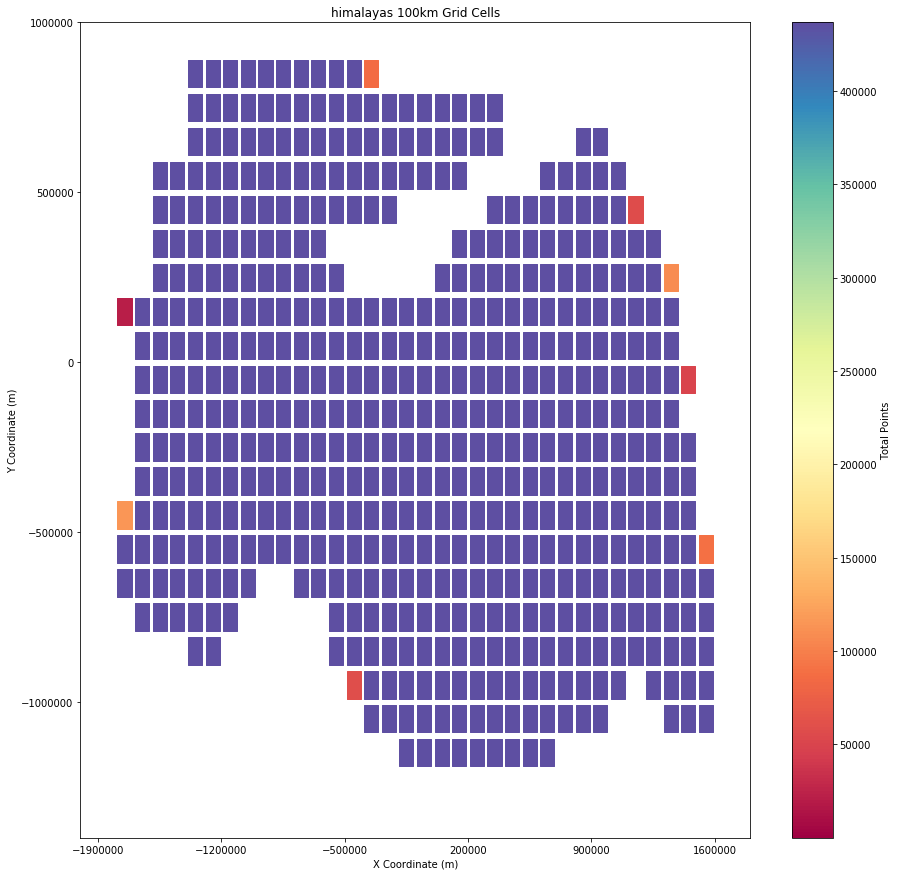

In [5]:

parentDs = 'mtngla'
dataSet = 'tdx2'
region='himalayas'

mtngla = generateGridCellImage(parentDs,dataSet,region)

#resG = generateGridCellImage('cryotempo','GRIS_BaseC_Q2','greenland')
#resG.savefig('greenland_2011.png')

#resA = generateGridCellImage('cryotempo','AIS_BaselineC_FilteredPC','antarctic')
#resA.savefig('antarctic_2011.png')

#oibG = generateGridCellImage('cryotempo','oib','greenland')


In [37]:
dir(type(ax))

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_axes_class',
 '_convert_dx',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_get_axis_list',
 '_get_view',
 '_init_axis',
 '_make_twin_axes',
 '_on_units_changed',
 '_parse_scatter_color_args',
 '_pcolorargs',
 '_process_unit_info',
 '_prop_order',
 '_quiver_units',
 '_remove_legend',
 '_sci',
 '_set_artist_props',
 '_set_gc_clip',
 '_set_lim_and_transforms',
 '_set_position',
 '_set_title_offset_trans',
 '_set_view',
 '_set_view_from_bbox',
 '_shared_x_axes',
 '_shared_y_axes',
 '_twinned_axes',
 '_update_image_limits',
 '_update_line_limits',
 '_update_patch_limits'

In [139]:

from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27018')

db = client['cryotempo']

collection = db.catalogue

rows = collection.aggregate([{'$match' : {'dsName':'GRIS_BaseC_Q2'}},{'$group' : { '_id' :  None, 'minLat' : {'$min':'$minLat'}, 'maxLat' :{'$max':'$maxLat'}, 'minLon' : {'$min':'$minLon'}, 'maxLon' :{'$max':'$maxLon'} }}])

print('Greenland Extent')
for row in rows:
    print(row)

rows = collection.aggregate([{'$match' : {'dsName':'AIS_BaselineC_FilteredPC'}},{'$group' : { '_id' :  None, 'minLat' : {'$min':'$minLat'}, 'maxLat' :{'$max':'$maxLat'}, 'minLon' : {'$min':'$minLon'}, 'maxLon' :{'$max':'$maxLon'} }}])

print('Antarctic Extent')
for row in rows:
    print(row)

    

Greenland Extent
{'_id': None, 'minLat': 60.05982837462768, 'maxLat': 83.65934528735883, 'minLon': 286.9447062840197, 'maxLon': 348.9215804798771}
Antarctic Extent
{'_id': None, 'minLat': -88.13821772109429, 'maxLat': -61.002671160589095, 'minLon': 1.0044843686904741e-07, 'maxLon': 359.99999987528423}


In [142]:
collection = db.swathDetails

results = collection.find()

for i, r in enumerate(results):
    if i < 10:
        print(r)


{'_id': ObjectId('5d383b49fb0ee047e4c9d3a2'), 'datasetName': 'GRIS_BaseC_Q2', 'region': 'greenland', 'catalogueName': 'catalogue', 'swathName': 'CS_LTA__SIR_SIN_2S_20110315T155232_20110315T155240_C001.nc', 'swathId': 7, 'year': 2011, 'month': 3, 'pointCount': 111988, 'insertTime': datetime.datetime(2019, 7, 24, 12, 4, 41), 'gridCells': [{'projection': 'NPS', 'x': -100000, 'y': -2100000, 'pointCount': 6135}, {'projection': 'NPS', 'x': -200000, 'y': -2100000, 'pointCount': 5159}, {'projection': 'NPS', 'x': -200000, 'y': -2000000, 'pointCount': 38423}, {'projection': 'NPS', 'x': -100000, 'y': -2000000, 'pointCount': 49649}]}
{'_id': ObjectId('5d383b49fb0ee047e4c9d3a1'), 'datasetName': 'GRIS_BaseC_Q2', 'region': 'greenland', 'catalogueName': 'catalogue', 'swathName': 'CS_LTA__SIR_SIN_2S_20130627T094822_20130627T094850_C001.nc', 'swathId': 2, 'year': 2013, 'month': 6, 'pointCount': 108126, 'insertTime': datetime.datetime(2019, 7, 24, 12, 4, 41), 'gridCells': [{'projection': 'NPS', 'x': 7000